In [2]:
import pandas as pd  #pacotes
import numpy as np   #calculo numerico
import glob          #listas
#Codigo para declarar um pyarrow parquet - Willian - 29/05/2018
import pyarrow.parquet as pq
#uproot serve para ler a partir o python um arquivo em tree root
#import uproot
import os, sys
from os import path
import datetime
import matplotlib as mp
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
%matplotlib inline

In [3]:
%run def_functions.ipynb
%run def_functions_hits.ipynb
%run def_functions_fits.ipynb


In [4]:
# para 30 dias

list_ON  = [
            '20250101','20250102','20250103','20250104','20250105','20250106','20250107',
            '20250108','20250109','20250110','20250111','20250112','20250113','20250114',
            '20250115','20250116','20250117','20250118','20250119','20250120','20250121',
            '20250122','20250123','20250124','20250125','20250126','20250127','20250128',
            '20250129','20250130'
           ]

list_OFF = [
            '20241117','20241118','20241119','20241120','20241121','20241122','20241123',
            '20241124','20241125','20241126','20241127','20241128','20241129','20241130',
            '20241201','20241202','20241203',#'20241204',
            '20241205','20241206','20241207',
            '20241208','20241209','20241210','20241211','20241212','20241213','20241214',
            '20241215','20241216','20241217'
           ]

list_PDT  = [
            '20241117','20241118','20241119','20241120','20241121','20241122','20241123',
            '20241124','20241125','20241126','20241127','20241128','20241129','20241130',
            '20241201','20241202','20241203','20241204','20241205','20241206','20241207',
            '20241208','20241209','20241210','20241211','20241212','20241213','20241214',
            '20241215','20241216','20241217','20241218','20241219','20241220','20241221',
            '20241222','20241223','20241224','20241225','20241226','20241227','20241228',
            '20241229','20241230','20241231',
            '20250101','20250102','20250103','20250104','20250105','20250106','20250107',
            '20250108','20250109','20250110','20250111','20250112','20250113','20250114',
            '20250115','20250116','20250117','20250118','20250119','20250120','20250121',
            '20250122','20250123','20250124','20250125','20250126','20250127','20250128',
            '20250129','20250130','20250131'
            ]


In [5]:
##save values - h_Sig_OFF2 (contém o sigma de cada bin dividido por 5dias)
def save_PD (dh_PDP, dh_PDD, dh_PDT, dh_Sig, sName):
    # dictionary of lists
    dict = {'dh_PDP': dh_PDP,
            'dh_PDD': dh_PDD,
            'dh_PDT': dh_PDT}
    
    dict2 = {'dh_Sig': dh_Sig}
 
    # creating a dataframe from dictionary
    dfw = pd.DataFrame(dict)
    dfw.to_parquet('data/Analise_ONOFF/'+sName+'.parq', compression='gzip')

    dfw2 = pd.DataFrame(dict2)
    dfw2.to_parquet('data/Analise_ONOFF/Sig_'+sName+'.parq', compression='gzip')

    del dict2
    del dict
    
##load values
def load_PD (sName): #(dh_PDP, dh_PDD, dh_PDT, dh_Sig, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/'+sName+'.parq')
    dfr2 = pd.read_parquet('data/Analise_ONOFF/Sig_'+sName+'.parq')
    return(dfr['dh_PDP'].values, dfr['dh_PDD'].values, dfr['dh_PDT'].values, dfr2['dh_Sig'].values)

##load values by day
def load_PD_byDay (sName): #(dh_PDP, dh_PDD, dh_PDT, dh_Sig, sName):
    dfr = pd.read_parquet('data/Analise_ONOFF/byDay/'+sName+'.parq')
    dfr2 = pd.read_parquet('data/Analise_ONOFF/byDay/Sig_'+sName+'.parq')
    return(dfr['dh_PDP'].values, dfr['dh_PDD'].values, dfr['dh_PDT'].values, dfr2['dh_Sig'].values)

    

In [6]:
def fnc_subtraction_ON_OFF (p_PDP_ON, p_PDP_OFF, s_lab_ON, s_lab_OFF, s_mult, escala_y0, escala_y1):
    fig=plt.figure(figsize=(12,5))

    plt.rcParams.update({'font.size': 15})

    maxElement = int(np.amax(p_PDP_ON)/5)

    hist_ON3, bins_ON3 = np.histogram(p_PDP_ON, bins=maxElement)
    hist_OFF, bins_OFF = np.histogram(p_PDP_OFF, bins=maxElement)


    hist_ONO_A, bins_ONO_all = np.histogram(p_PDP_ON, bins=maxElement)
    hist_OFF_A, bins_OFF_all = np.histogram(p_PDP_OFF, bins=maxElement)

    diff_hist = hist_ONO_A - hist_OFF_A  # somente com prompt que está relacionado com a energia do neutrino
    diff_hist2 = np.append(diff_hist, [0])

    errbar_sigma_day = []
    for inf in range(len(hist_ONO_A)):
        errbar_sigma_day.append((hist_ONO_A[inf] + hist_OFF_A[inf])**0.5)
    

    axprops = dict(yticks=[])
    axs = []

    axs.append(fig.add_axes([0.1, 1.0, 0.8, 0.9], **axprops))
    axs.append(fig.add_axes([0.1, 0.4, 0.8, 0.5], **axprops))

    axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins_ON3[1:])),hist_ON3, '-', drawstyle='steps', color='red', label='ON') ##bins_ON possui um elemento a mais sempre
    axs[0].plot(fnt_Positron2Neutrino(fnt_pe2MeV(bins_OFF[1:])),hist_OFF, '-', drawstyle='steps', color='blue', label='OFF') 
    axs[1].errorbar(fnt_Positron2Neutrino(fnt_pe2MeV(bins_OFF[1:])),diff_hist2[1:], yerr=errbar_sigma_day, #[1:] , 
                    marker='o', color='blue', 
                    linestyle='None', capsize=4, label='dado')

    axs[0].grid(True)
    axs[1].grid(True)

    axs[1].axhline(0,color='red')

    axs[0].legend(loc='upper right')
    axs[1].legend(loc='upper right')
    axs[0].set_ylabel('dR/dE', size=16)
    axs[1].set_xlabel('Energia (MeV)', size=16)
    axs[0].set_yticks(np.arange(0, hist_ON3[0], escala_y0))
    axs[1].set_yticks(np.arange(-200, diff_hist2[1:][0]+errbar_sigma_day[0]*2+escala_y1, escala_y1))

    axs[0].set_title('Distribuição de Prompt >> Antineutrino em 30 dias \n '+
                     s_lab_ON + ' / '+
                     s_lab_OFF + ' \n'+
                     r'(3MeV < E$_{Prompt}$ < 10MeV; 1,60MeV < E$_{Delay}$ < 7,12MeV; 8$\mu$s < t < 50$\mu$s; >='+s_mult+'PMTs)', size=16,y=1.02)
    #axs[1].set_title('Subtração ON/OFF de Prompt \n '+
    #                 s_lab_ON + ' / '+
    #                 s_lab_OFF + ' \n')

    #plt.savefig('histogramas/Hist_PD_ON_X_OFF_Subtrac_updown.png')
    plt.show()

    print('Excessos total')
    print(sum(diff_hist2))
    print('Excessos até 7MeV')
    print(sum(diff_hist2[:19]))
    print('Excessos até 6MeV')
    print(sum(diff_hist2[:12]))
    print('Excessos de 6 a 7MeV')
    print(sum(diff_hist2[12:19]))
    
    return(sum(diff_hist2[:12]),sum(diff_hist2[12:19]))  ## retornando excessos até 6MeV e de 6 a 7MeV


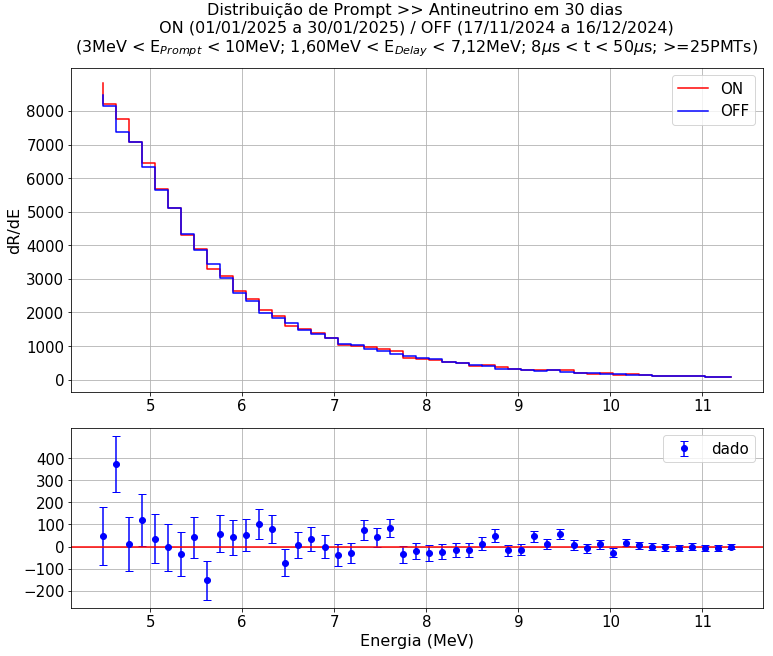

Excessos total
1238
Excessos até 7MeV
1121
Excessos até 6MeV
923
Excessos de 6 a 7MeV
198


In [96]:
s_mult = '25'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_25, i_excess_ON67_25 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 1000, 100)

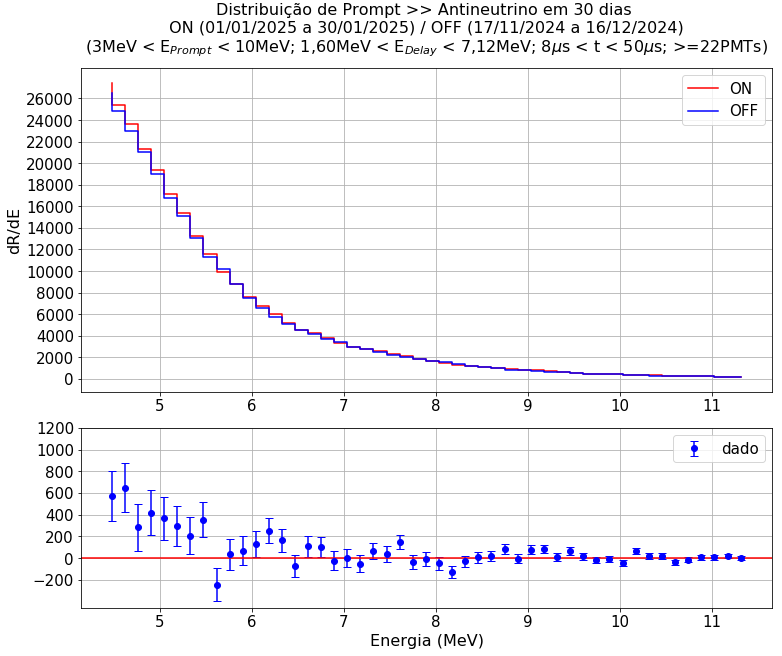

Excessos total
4947
Excessos até 7MeV
4649
Excessos até 6MeV
4000
Excessos de 6 a 7MeV
649


In [97]:
s_mult = '22'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_22, i_excess_ON67_22 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 2000, 200)

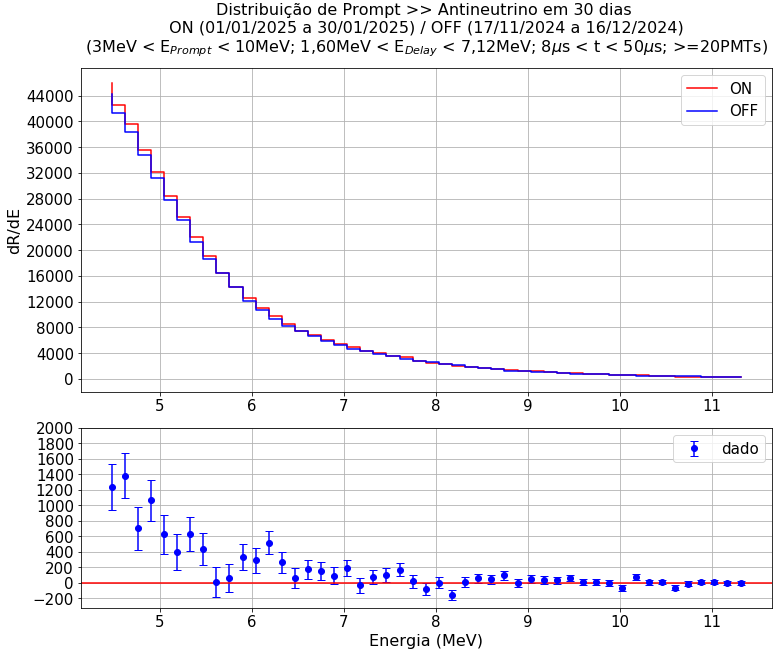

Excessos total
10877
Excessos até 7MeV
10178
Excessos até 6MeV
8616
Excessos de 6 a 7MeV
1562


In [98]:
s_mult = '20'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_20, i_excess_ON67_20 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 4000, 200)

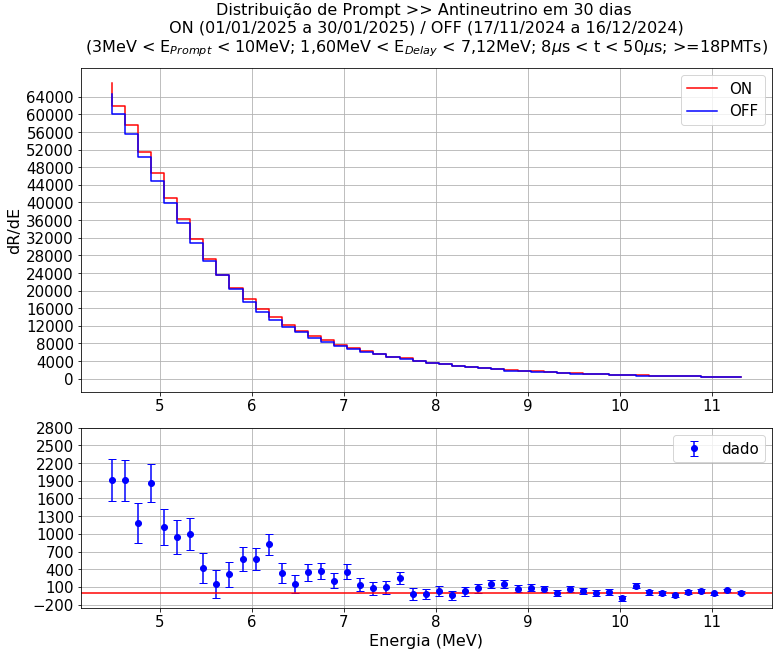

Excessos total
18497
Excessos até 7MeV
16898
Excessos até 6MeV
14100
Excessos de 6 a 7MeV
2798


In [99]:
s_mult = '18'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_18, i_excess_ON67_18 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 4000, 300)

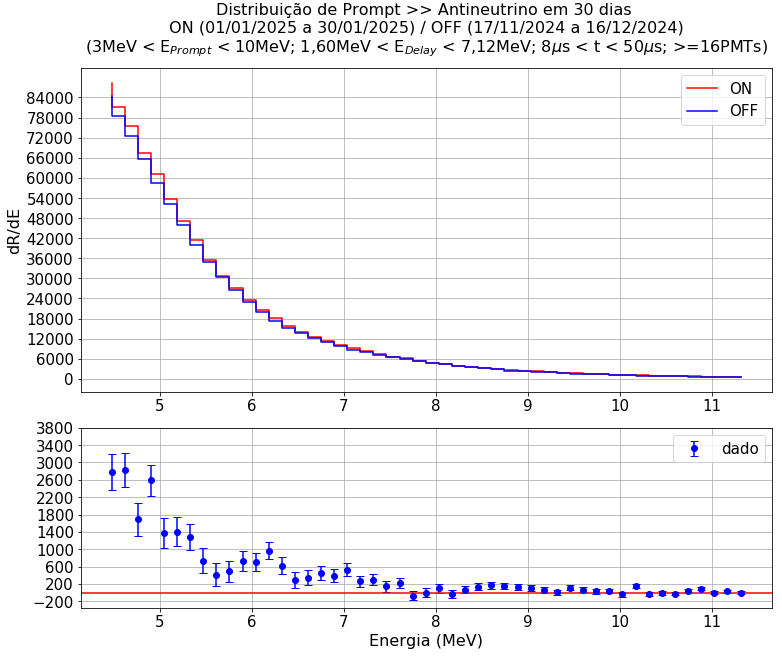

Excessos total
26709
Excessos até 7MeV
24004
Excessos até 6MeV
20242
Excessos de 6 a 7MeV
3762


In [100]:
s_mult = '16'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_16, i_excess_ON67_16 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 6000, 400)

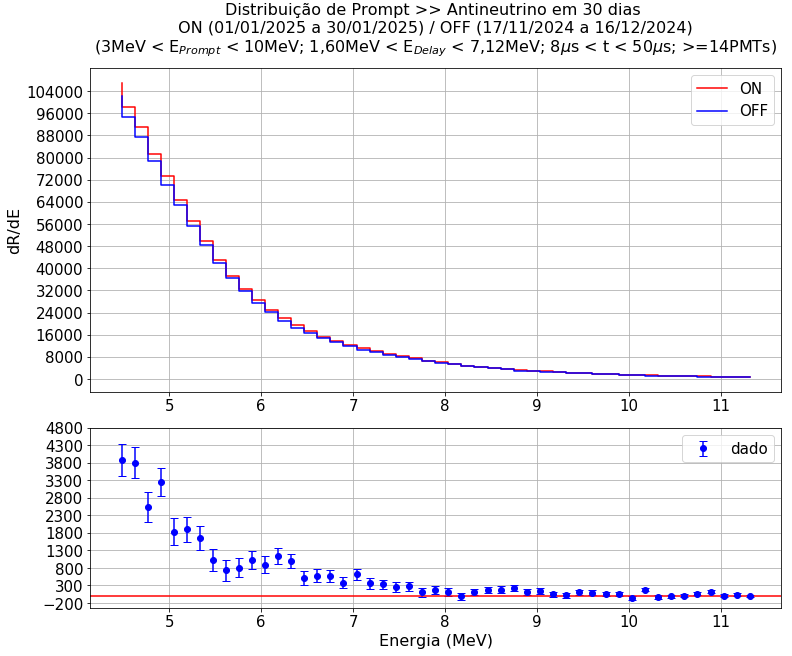

Excessos total
36373
Excessos até 7MeV
32503
Excessos até 6MeV
27430
Excessos de 6 a 7MeV
5073


In [33]:
s_mult = '14'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_14, i_excess_ON67_14 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 8000, 500)

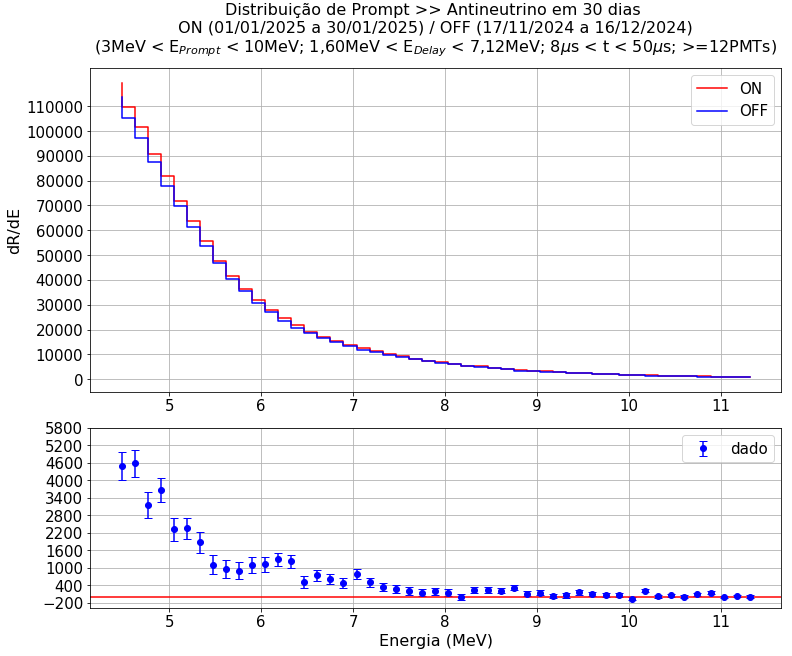

Excessos total
42813
Excessos até 7MeV
38213
Excessos até 6MeV
32270
Excessos de 6 a 7MeV
5943


In [102]:
s_mult = '12'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_12, i_excess_ON67_12 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 10000, 600)

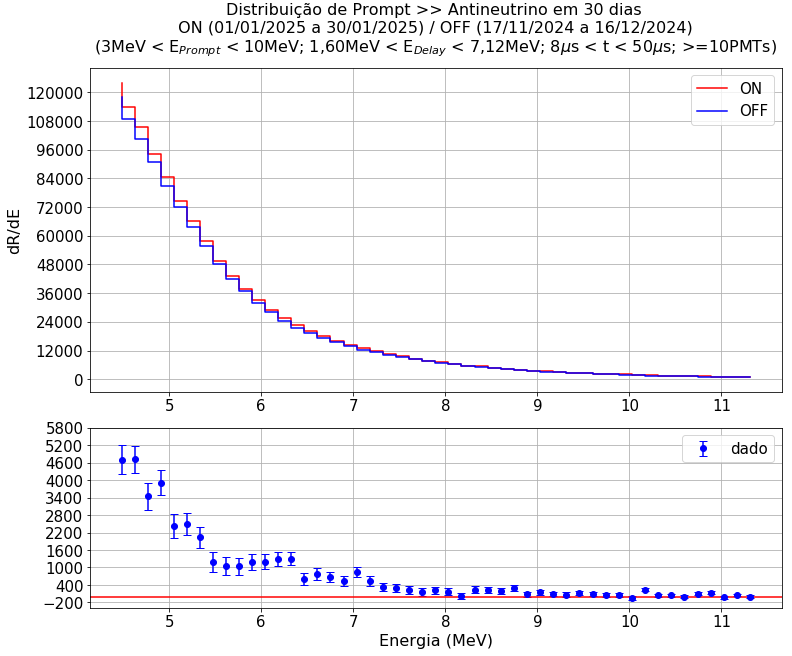

Excessos total
45751
Excessos até 7MeV
40775
Excessos até 6MeV
34405
Excessos de 6 a 7MeV
6370


In [103]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 12000, 600)

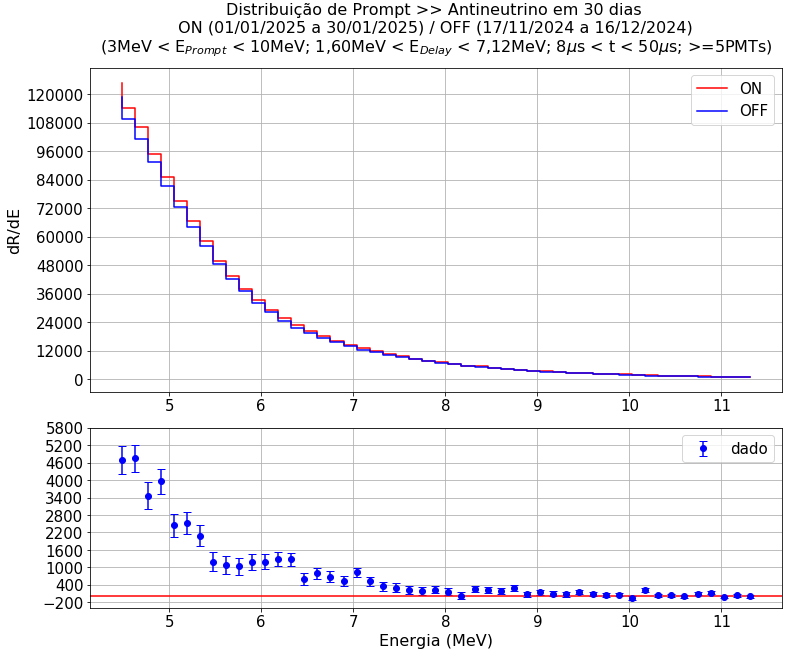

Excessos total
46119
Excessos até 7MeV
41063
Excessos até 6MeV
34713
Excessos de 6 a 7MeV
6350


In [104]:
s_mult = '5'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_5, i_excess_ON67_5 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 12000, 600)

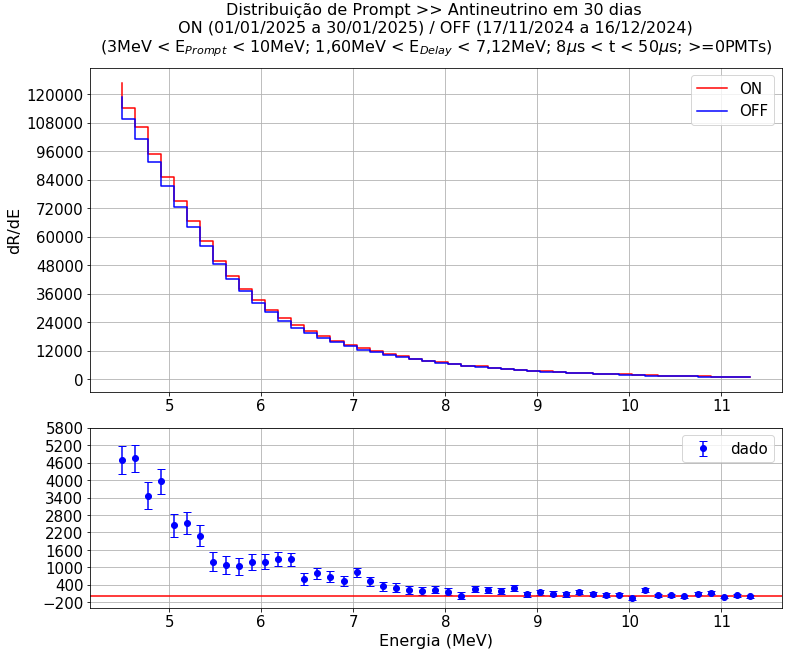

Excessos total
46117
Excessos até 7MeV
41061
Excessos até 6MeV
34711
Excessos de 6 a 7MeV
6350


In [105]:
s_mult = '0'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF_30_m'+s_mult)
i_excess_ON_0, i_excess_ON67_0 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 16/12/2024)', s_mult, 12000, 600)

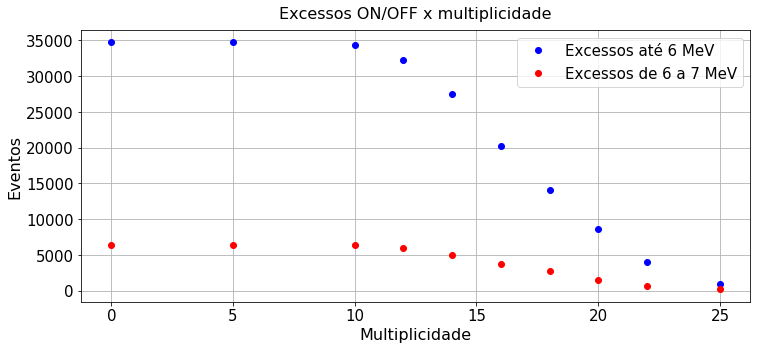

In [109]:
fig=plt.figure(figsize=(12,5))
plt.rcParams.update({'font.size': 15})

v_mult = [25,22,20,18,16,14,12,10,5,0]
v_excess = [i_excess_ON_25,i_excess_ON_22,i_excess_ON_20,i_excess_ON_18,i_excess_ON_16,
            i_excess_ON_14,i_excess_ON_12,i_excess_ON_10,i_excess_ON_5,i_excess_ON_0]
v_excess67 = [i_excess_ON67_25,i_excess_ON67_22,i_excess_ON67_20,i_excess_ON67_18,i_excess_ON67_16,
              i_excess_ON67_14,i_excess_ON67_12,i_excess_ON67_10,i_excess_ON67_5,i_excess_ON67_0]

plt.plot(v_mult,v_excess, 'o', color='blue', label='Excessos até 6 MeV') 
plt.plot(v_mult,v_excess67, 'o', color='red', label='Excessos de 6 a 7 MeV') 

plt.grid(True)
plt.legend(loc='upper right')
plt.ylabel('Eventos', size=16)
plt.xlabel('Multiplicidade', size=16)

plt.title('Excessos ON/OFF x multiplicidade', size=16,y=1.02)

plt.savefig('histogramas/Excessos_x_Multip_2025.png')
plt.show()
    


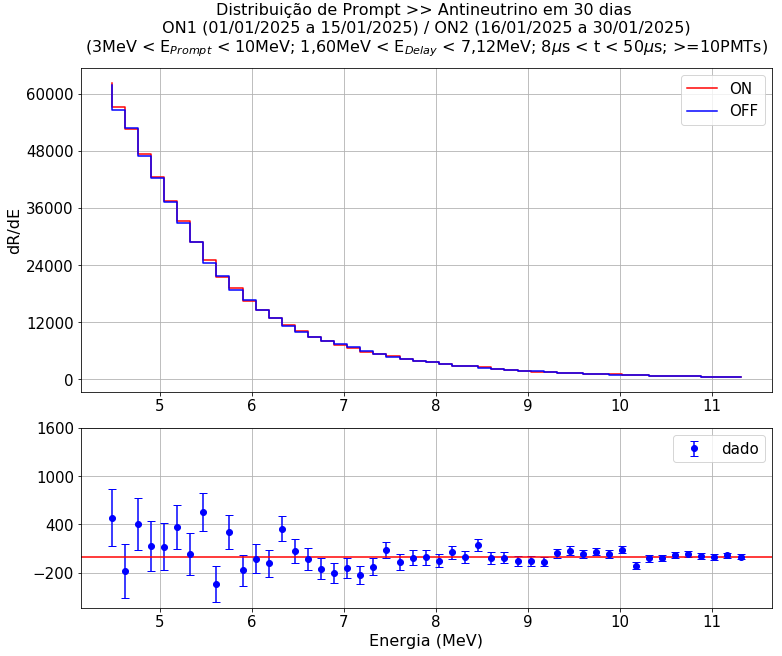

Excessos total
1832
Excessos até 7MeV
2168
Excessos até 6MeV
2244
Excessos de 6 a 7MeV
-76


In [6]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON1_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_ON2_15_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON1 (01/01/2025 a 15/01/2025)', 'ON2 (16/01/2025 a 30/01/2025)', s_mult, 12000, 600)

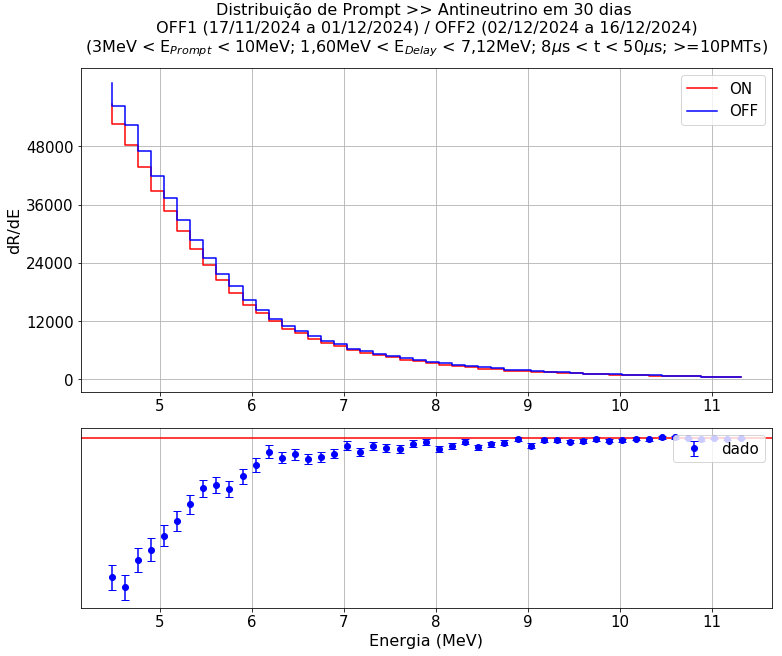

Excessos total
-37739
Excessos até 7MeV
-33921
Excessos até 6MeV
-30295
Excessos de 6 a 7MeV
-3626


In [16]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_OFF1_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF2_15_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'OFF1 (17/11/2024 a 01/12/2024)', 'OFF2 (02/12/2024 a 16/12/2024)', s_mult, 12000, 600)

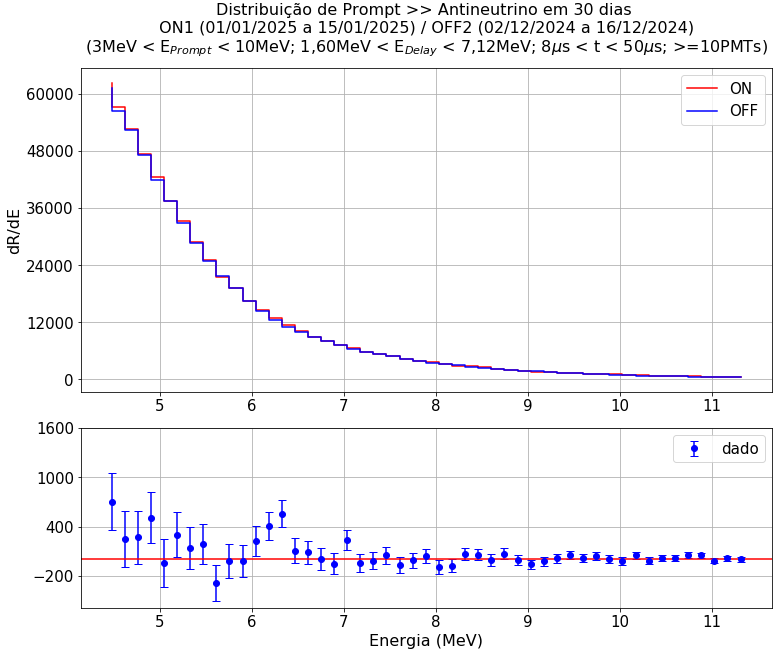

Excessos total
4922
Excessos até 7MeV
4511
Excessos até 6MeV
3177
Excessos de 6 a 7MeV
1334


In [17]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON1_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF2_15_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON1 (01/01/2025 a 15/01/2025)', 'OFF2 (02/12/2024 a 16/12/2024)', s_mult, 12000, 600)

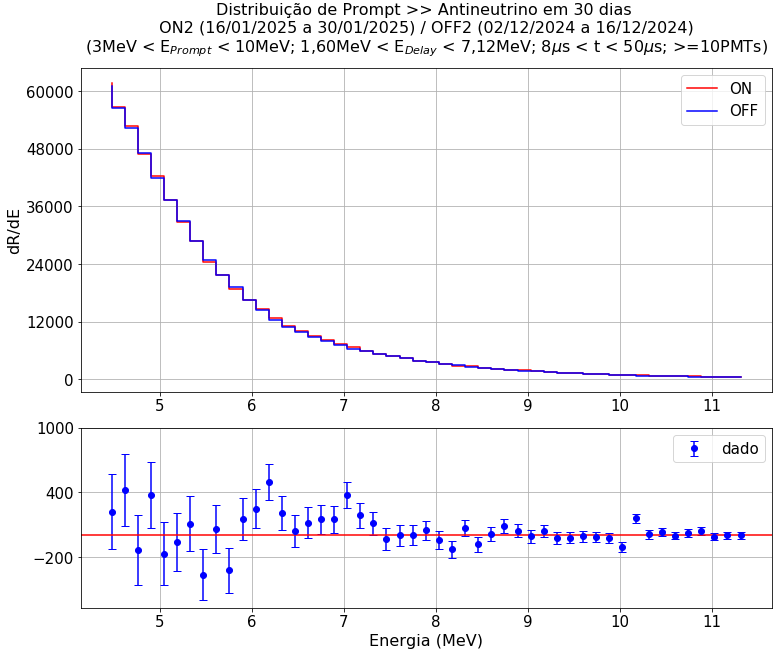

Excessos total
3090
Excessos até 7MeV
2343
Excessos até 6MeV
933
Excessos de 6 a 7MeV
1410


In [15]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON2_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF2_15_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON2 (16/01/2025 a 30/01/2025)', 'OFF2 (02/12/2024 a 16/12/2024)', s_mult, 12000, 600)

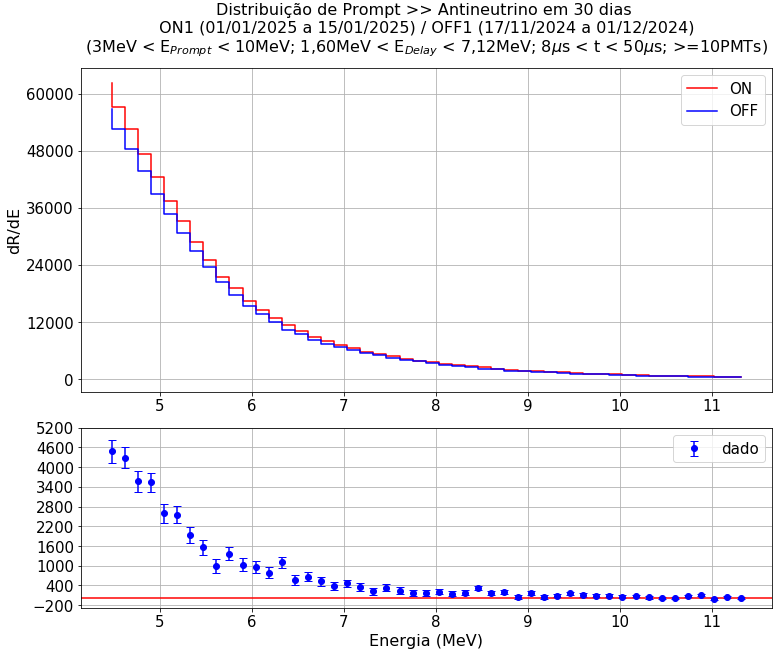

Excessos total
42661
Excessos até 7MeV
38432
Excessos até 6MeV
33472
Excessos de 6 a 7MeV
4960


In [14]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON1_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_15_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON1 (01/01/2025 a 15/01/2025)', 'OFF1 (17/11/2024 a 01/12/2024)', s_mult, 12000, 600)

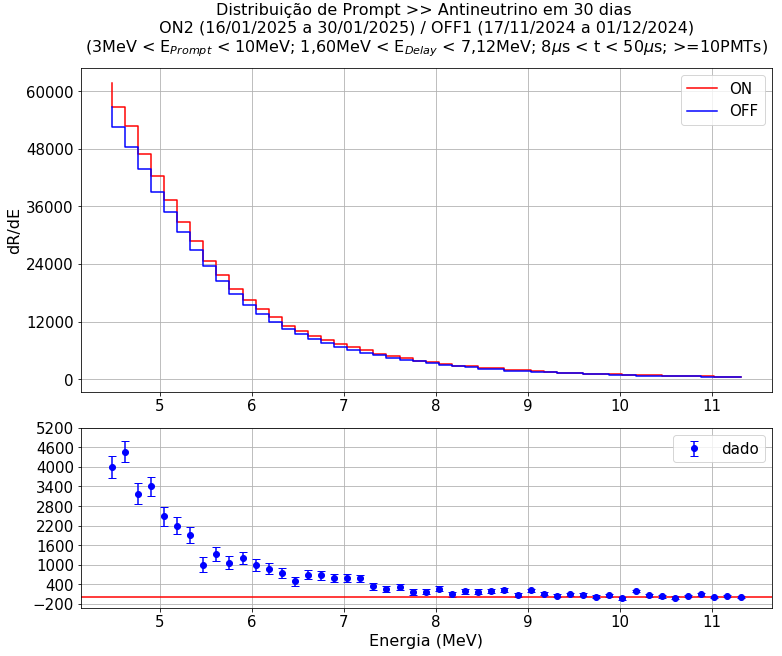

Excessos total
40829
Excessos até 7MeV
36264
Excessos até 6MeV
31228
Excessos de 6 a 7MeV
5036


In [18]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON2_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_15_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON2 (16/01/2025 a 30/01/2025)', 'OFF1 (17/11/2024 a 01/12/2024)', s_mult, 12000, 600)

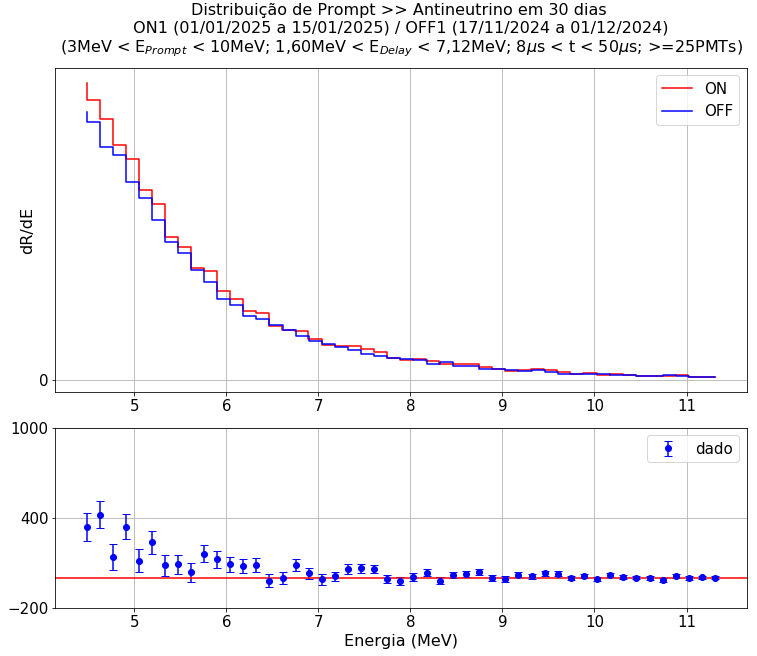

Excessos total
3238
Excessos até 7MeV
2873
Excessos até 6MeV
2527
Excessos de 6 a 7MeV
346


In [6]:
s_mult = '25'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON1_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_15_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON1 (01/01/2025 a 15/01/2025)', 'OFF1 (17/11/2024 a 01/12/2024)', s_mult, 12000, 600)


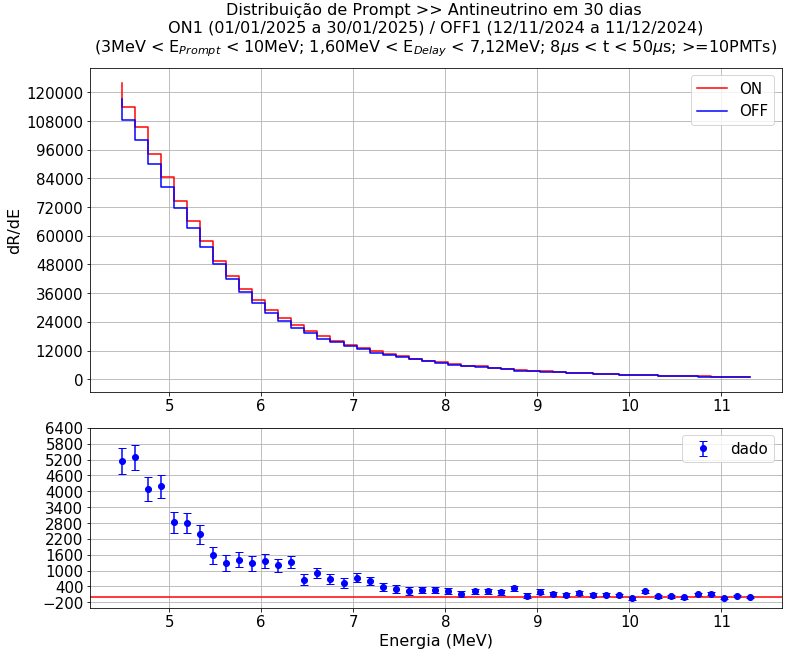

Excessos total
50998
Excessos até 7MeV
45660
Excessos até 6MeV
39023
Excessos de 6 a 7MeV
6637


In [7]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_30_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON1 (01/01/2025 a 30/01/2025)', 'OFF1 (12/11/2024 a 11/12/2024)', s_mult, 12000, 600)


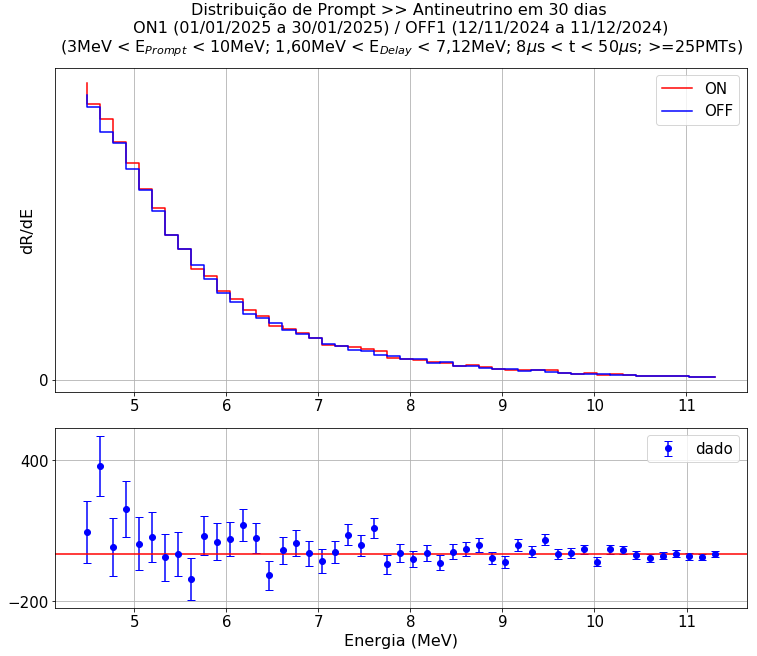

Excessos total
1680
Excessos até 7MeV
1430
Excessos até 6MeV
1194
Excessos de 6 a 7MeV
236


In [8]:
s_mult = '25'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON_30_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_30_m'+s_mult)
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON1 (01/01/2025 a 30/01/2025)', 'OFF1 (12/11/2024 a 11/12/2024)', s_mult, 12000, 600)


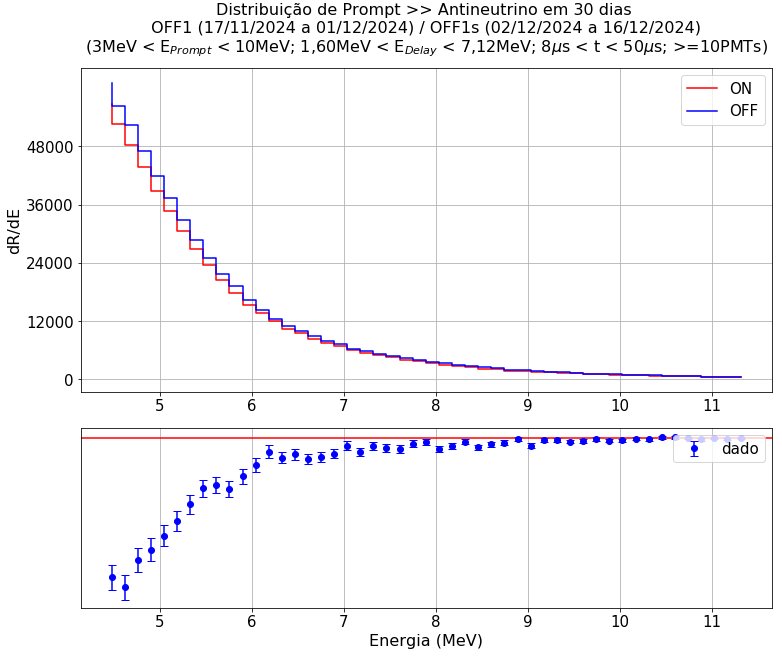

Excessos total
-37739
Excessos até 7MeV
-33921
Excessos até 6MeV
-30295
Excessos de 6 a 7MeV
-3626


In [10]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_OFF1_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_15_m'+s_mult+'_shift')
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'OFF1 (17/11/2024 a 01/12/2024)', 'OFF1s (02/12/2024 a 16/12/2024)', s_mult, 12000, 600)

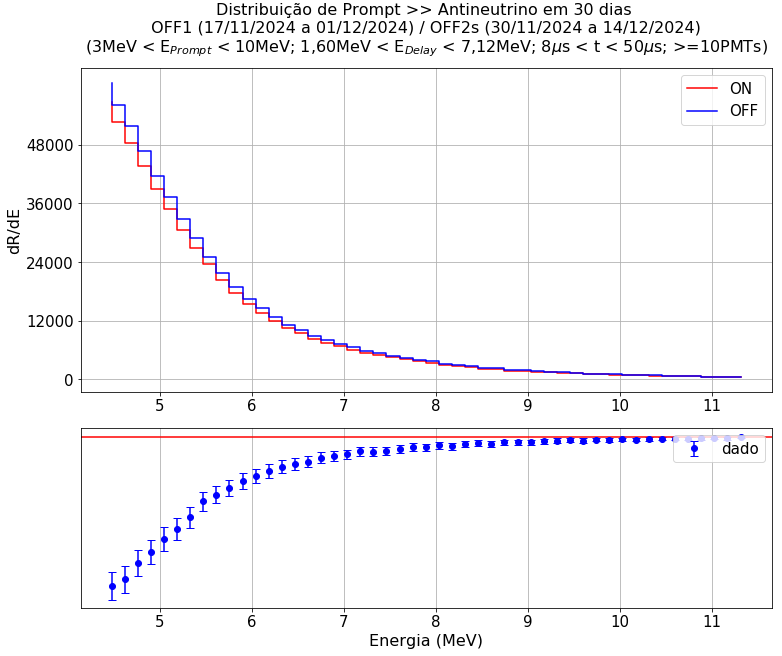

Excessos total
-38094
Excessos até 7MeV
-33751
Excessos até 6MeV
-29024
Excessos de 6 a 7MeV
-4727


In [6]:
s_mult = '10'
#h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_OFF1_15_m'+s_mult)
#h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_OFF5_15_m'+s_mult+'_shift')
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_OFF1_15_m'+s_mult)
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF7_15_m'+s_mult+'_shift')
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'OFF1 (17/11/2024 a 01/12/2024)', 'OFF2s (30/11/2024 a 14/12/2024)', s_mult, 12000, 500)

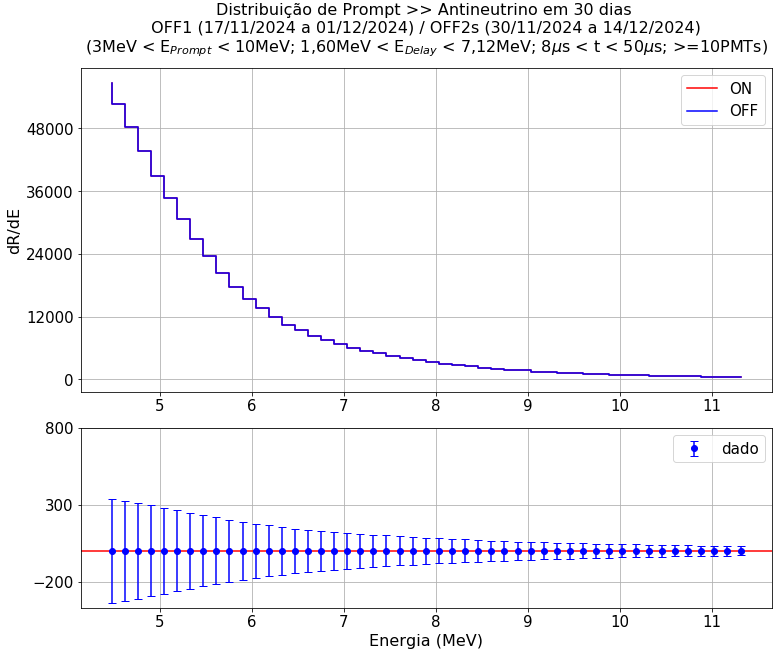

Excessos total
0
Excessos até 7MeV
0
Excessos até 6MeV
0
Excessos de 6 a 7MeV
0


In [21]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_OFF1_15_m10_test')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_15_m10')
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'OFF1 (17/11/2024 a 01/12/2024)', 'OFF2s (30/11/2024 a 14/12/2024)', s_mult, 12000, 500)

### Os excessos OFF começaram no dia 04/12/2024 (PD_OFF4_15_m10_test - 20/11 a 04/12)
### Até o dia 03/12/2024 (PD_OFF5_15_m10_test - 19/11 a 03/12) 
### não dava excesso em relação ao OFF de 17/11 a 01/12/2024
### Outro detalhe: PD_OFF7_15_m10_text e PD_OFF1_15_m10 são o mesmo período sem excesso

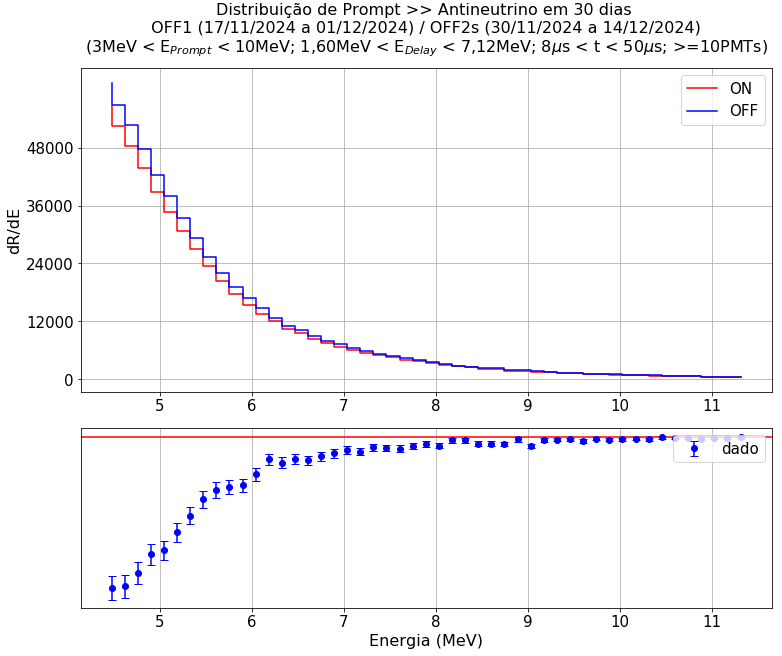

Excessos total
-44267
Excessos até 7MeV
-40078
Excessos até 6MeV
-35301
Excessos de 6 a 7MeV
-4777


In [28]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_OFF1_15_m10')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF8_15_m10_test')
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'OFF1 (17/11/2024 a 01/12/2024)', 'OFF2s (30/11/2024 a 14/12/2024)', s_mult, 12000, 500)

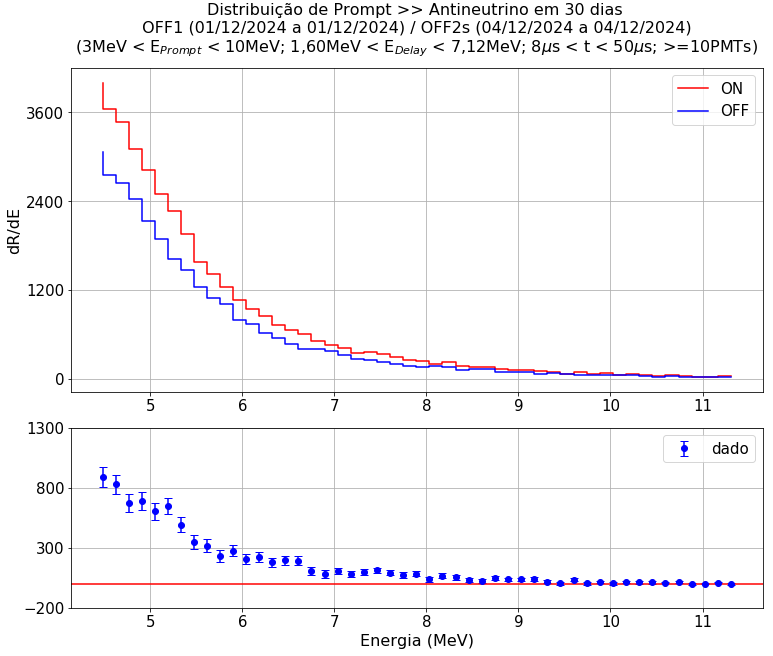

Excessos total
9297
Excessos até 7MeV
8123
Excessos até 6MeV
6937
Excessos de 6 a 7MeV
1186


In [31]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_OFF1_15_m10_byDay')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF4_15_m10_byDay')
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'OFF1 (01/12/2024 a 01/12/2024)', 'OFF2s (04/12/2024 a 04/12/2024)', s_mult, 1200, 500)

### By Day

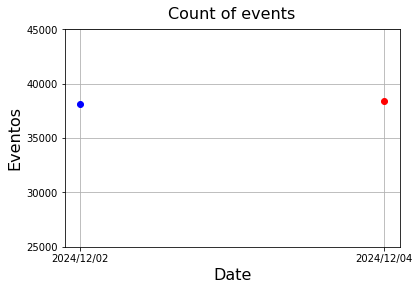

In [14]:
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD_byDay ( 'PD_m10_Date_20241201')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD_byDay ( 'PD_m10_Date_20241205')


plt.plot(['2024/12/02'],[len(h_PDP_ON)], 'o', color='blue') #, label='Excessos até 6 MeV') 
plt.plot(['2024/12/04'],[len(h_PDP_OFF)], 'o', color='red') #, label='Excessos de 6 a 7 MeV') 

plt.grid(True)
#plt.legend(loc='upper right')
plt.ylabel('Eventos', size=16)
plt.xlabel('Date', size=16)
plt.yticks(np.arange(25000, 50000, 5000))

plt.title('Count of events', size=16,y=1.02)

plt.savefig('histogramas/CountOfEvents_2025.png')
plt.show()

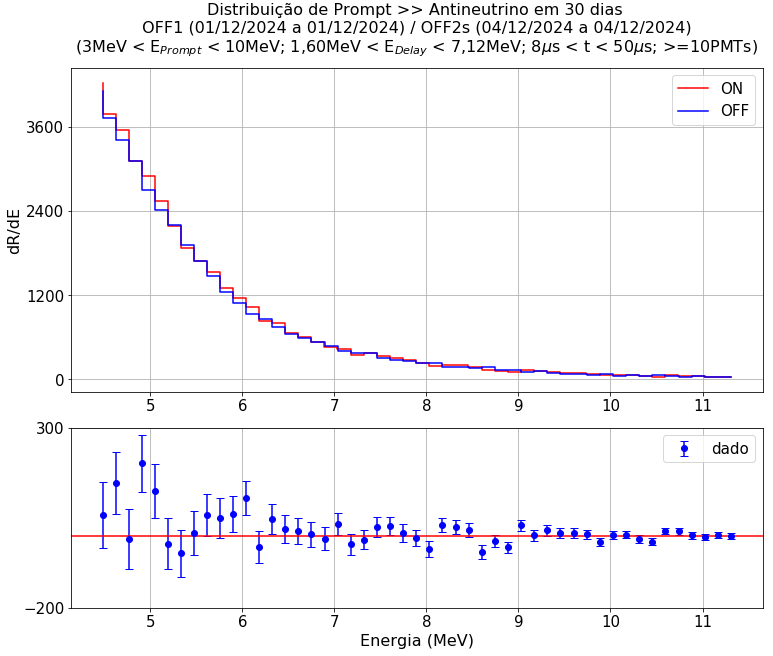

Excessos total
945
Excessos até 7MeV
899
Excessos até 6MeV
752
Excessos de 6 a 7MeV
147


In [31]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD_byDay ( 'PD_m10_Date_20250110')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD_byDay ( 'PD_m10_Date_20241117')
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'OFF1 (01/12/2024 a 01/12/2024)', 'OFF2s (04/12/2024 a 04/12/2024)', s_mult, 1200, 500)

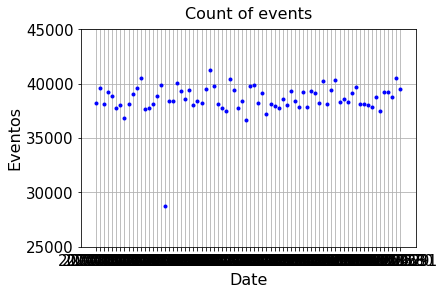

In [35]:
ind = 0

while (ind < len(list_PDT)):
    s_Date = list_PDT[ind]
    
    h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD_byDay ( 'PD_m10_Date_'+s_Date)

    plt.plot([s_Date],[len(h_PDP_ON)], '.', color='blue') #, label='Excessos até 6 MeV') 
    ind = ind + 1
        

plt.grid(True)
#plt.legend(loc='upper right')
plt.ylabel('Eventos', size=16)
plt.xlabel('Date', size=16)
tplt.yticks(np.arange(25000, 50000, 5000))

plt.title('Count of events', size=16,y=1.02)

plt.savefig('histogramas/CountOfEvents_2025.png')
plt.show()

In [41]:
ind = 0

h_PDP_ON=[]
h_PDD_ON=[]
h_PDT_ON=[]
hg_Sig_ON=[]

while (ind < len(list_ON)):
    s_Date = list_ON[ind]
    
    h_PDP_ON_day, h_PDD_ON_day, h_PDT_ON_day, hg_Sig_ON_day = load_PD_byDay ( 'PD_m10_Date_'+s_Date)
    h_PDP_ON.extend(h_PDP_ON_day)
    h_PDD_ON.extend(h_PDD_ON_day)
    h_PDT_ON.extend(h_PDT_ON_day)
    hg_Sig_ON.extend(hg_Sig_ON_day)
    #plt.plot([s_Date],[len(h_PDP_ON)], '.', color='blue') #, label='Excessos até 6 MeV') 
    ind = ind + 1
        
h_PDP_OFF=[]
h_PDD_OFF=[]
h_PDT_OFF=[]
hg_Sig_OFF=[]
ind = 0

while (ind < len(list_OFF)):
    s_Date = list_OFF[ind]
    
    h_PDP_OFF_day, h_PDD_OFF_day, h_PDT_OFF_day, hg_Sig_OFF_day = load_PD_byDay ( 'PD_m10_Date_'+s_Date)
    h_PDP_OFF.extend(h_PDP_OFF_day)
    h_PDD_OFF.extend(h_PDD_OFF_day)
    h_PDT_OFF.extend(h_PDT_OFF_day)
    hg_Sig_OFF.extend(hg_Sig_OFF_day)
    #plt.plot([s_Date],[len(h_PDP_ON)], '.', color='blue') #, label='Excessos até 6 MeV') 
    ind = ind + 1

'''
plt.grid(True)
#plt.legend(loc='upper right')
plt.ylabel('Eventos', size=16)
plt.xlabel('Date', size=16)
plt.yticks(np.arange(25000, 50000, 5000))

plt.title('Count of events', size=16,y=1.02)

plt.savefig('histogramas/CountOfEvents_2025.png')
plt.show()
'''

"\nplt.grid(True)\n#plt.legend(loc='upper right')\nplt.ylabel('Eventos', size=16)\nplt.xlabel('Date', size=16)\nplt.yticks(np.arange(25000, 50000, 5000))\n\nplt.title('Count of events', size=16,y=1.02)\n\nplt.savefig('histogramas/CountOfEvents_2025.png')\nplt.show()\n"

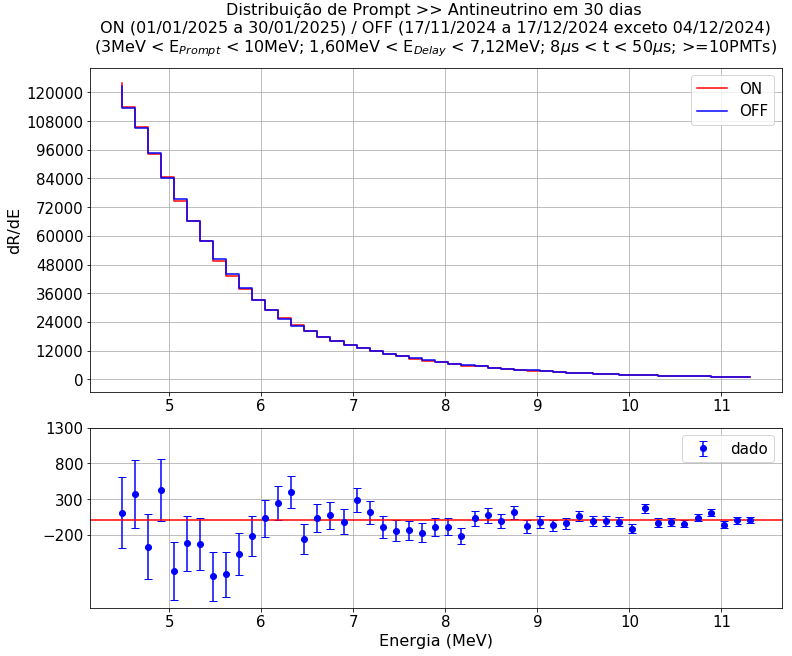

Excessos total
-1688
Excessos até 7MeV
-1178
Excessos até 6MeV
-1680
Excessos de 6 a 7MeV
502


In [43]:
i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (17/11/2024 a 17/12/2024 exceto 04/12/2024)', s_mult, 12000, 500)

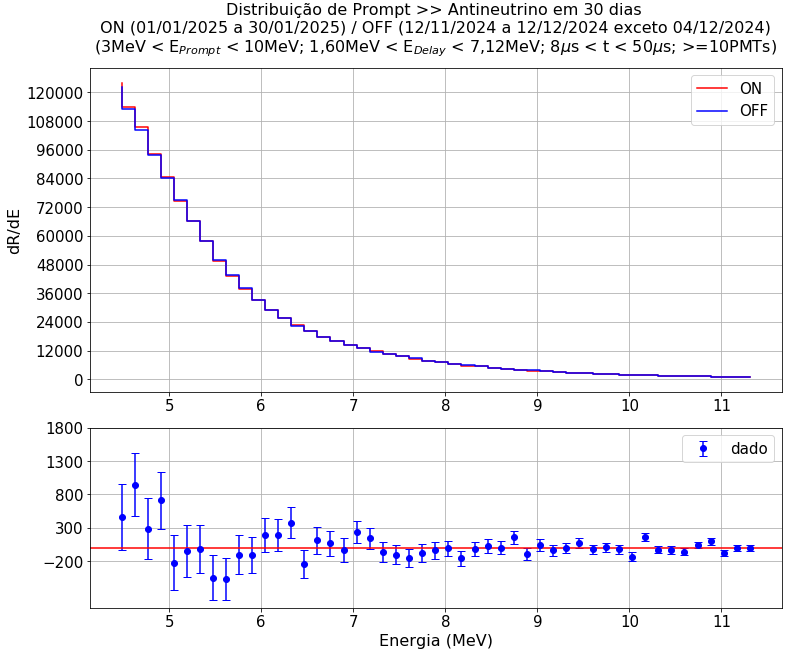

Excessos total
3285
Excessos até 7MeV
3451
Excessos até 6MeV
2784
Excessos de 6 a 7MeV
667


In [9]:
s_mult = '10'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON1_30d_m10_v2')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_30d_m10_v2')

i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (12/11/2024 a 12/12/2024 exceto 04/12/2024)', s_mult, 12000, 500)

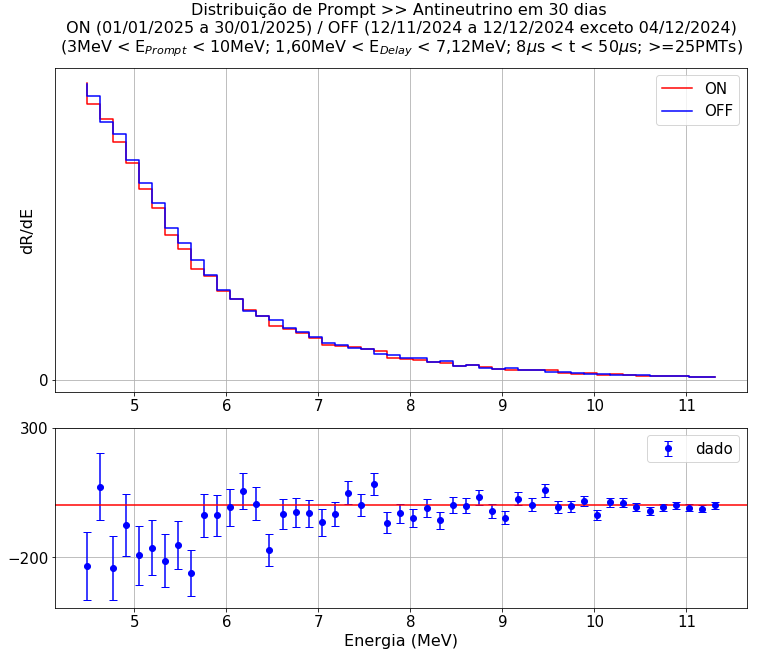

Excessos total
-1897
Excessos até 7MeV
-1705
Excessos até 6MeV
-1493
Excessos de 6 a 7MeV
-212


In [10]:
s_mult = '25'
h_PDP_ON, h_PDD_ON, h_PDT_ON, hg_Sig_ON = load_PD ( 'PD_ON1_30d_m25_v2')
h_PDP_OFF, h_PDD_OFF, h_PDT_OFF, hg_Sig_OFF = load_PD ( 'PD_OFF1_30d_m25_v2')

i_excess_ON_10, i_excess_ON67_10 = fnc_subtraction_ON_OFF(h_PDP_ON, h_PDP_OFF, 'ON (01/01/2025 a 30/01/2025)', 'OFF (12/11/2024 a 12/12/2024 exceto 04/12/2024)', s_mult, 12000, 500)